In [ ]:
import os
for dir in ['service', 'data', 'model']:
    if not os.path.exists(dir):
        os.makedirs(dir)

In [ ]:
%%writefile service/utils.py

import os
import random
import numpy as np
import torch

def reset_seeds(func, seed=42):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed) # 파이썬 환경변수 시드 고정
  np.random.seed(seed)
  torch.manual_seed(seed) # cpu 연산 무작위 고정
  torch.cuda.manual_seed(seed) # gpu 연산 무작위 고정
  torch.backends.cudnn.deterministic = True  # cuda 라이브러리에서 Deterministic(결정론적)으로 예측하기 (예측에 대한 불확실성 제거 )

  def wrapper_func(*args, **kwargs):
    return func(*args, **kwargs)

  return wrapper_func

Writing service/utils.py


In [ ]:
!pip install optuna
!pip install catboost xgboost lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd

In [ ]:
from service.utils import reset_seeds

# 데이터 로드

# EDA

In [ ]:
import plotly.express as px
import plotly.graph_objs as go
import numpy as np

- surived:0=사망, 1=생존
- pclass: 1=1등석, 2=2등석, 3=3등석
- name: 이름
- gender:male=남성, female=여성
- age: 나이
- sibSp: 타이타닉 호에 동승한 자매/배우자의 수
- parch: 타이타닉 호에 동승한 부모/자식의 수
- ticket: 티켓 번호
- fare: 승객 요금
- cabin: 방 호수
- embarked: 탑승지; C=셰르부르, Q=퀴즈타운, S=사우샘프턴

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1806 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  1806 non-null   int64  
 1   survived     1806 non-null   int64  
 2   pclass       1806 non-null   int64  
 3   name         1806 non-null   object 
 4   gender       1806 non-null   object 
 5   age          1449 non-null   float64
 6   sibsp        1806 non-null   int64  
 7   parch        1806 non-null   int64  
 8   ticket       1806 non-null   object 
 9   fare         1806 non-null   float64
 10  cabin        402 non-null    object 
 11  embarked     1803 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 183.4+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  393 non-null    int64  
 1   pclass       393 non-null    int64  
 2   name         393 non-null    object 
 3   gender       393 non-null    object 
 4   age          310 non-null    float64
 5   sibsp        393 non-null    int64  
 6   parch        393 non-null    int64  
 7   ticket       393 non-null    object 
 8   fare         392 non-null    float64
 9   cabin        97 non-null     object 
 10  embarked     392 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 33.9+ KB


In [ ]:
train.head()

,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,0,2,"Wheeler, Mr. Edwin Frederick""""",male,NaN,0,0,SC/PARIS 2159,12.8750,NaN,S
1,1,0,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q
2,2,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S
3,3,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S
4,4,0,2,"Hold, Mr. Stephen",male,44.0,1,0,26707,26.0000,NaN,S


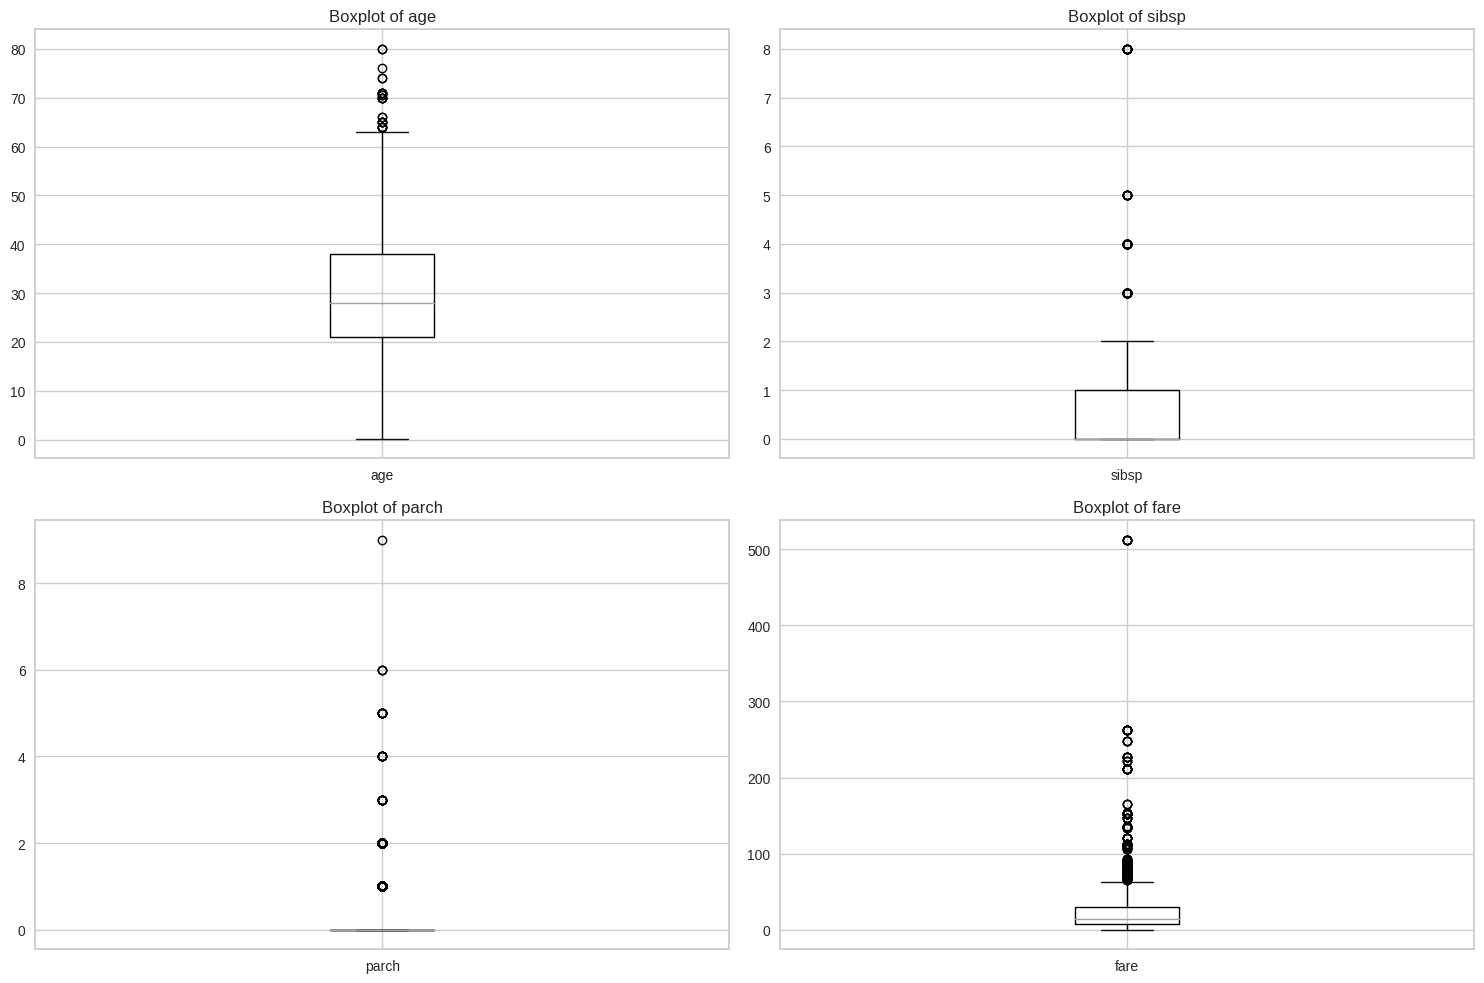

In [ ]:
# 박스 플롯을 통해 이상치를 시각적으로 확인
import matplotlib.pyplot as plt

# 연속형 변수들에 대해 박스 플롯을 그려서 이상치를 확인
numeric_columns = ['age', 'sibsp', 'parch', 'fare']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(2, 2, i)
    train.boxplot(column=col)
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

In [ ]:
# 1. 생존자 수와 사망자 수 시각화
fig1 = px.histogram(train, x='survived', color='survived', title='Survived vs Dead')
fig1.show()

In [ ]:
# 2. Pclass(티켓 등급)와 생존율 시각화
fig2 = px.histogram(train, x='pclass', color='survived', barmode='group', title='Pclass vs Survived')
fig2.show()

In [ ]:
# 3. 성별에 따른 생존율 시각화
fig3 = px.histogram(train, x='gender', color='survived', barmode='group', title='Gender vs Survived')
fig3.show()

In [ ]:
# 4. 나이 분포 시각화 및 생존율 분석
fig4 = px.histogram(train, x='age', color='survived', nbins=30, title='Age Distribution')
fig4.show()

In [ ]:
# 5. 상관관계 히트맵
corr_matrix = train[['survived', 'pclass', 'age', 'sibsp', 'parch', 'fare']].corr()
fig6 = go.Figure(data=go.Heatmap(
        z=corr_matrix.values,
        x=corr_matrix.columns,
        y=corr_matrix.columns,
        colorscale='Viridis'))
fig6.update_layout(title='Feature Correlation Heatmap')
fig6.show()

In [ ]:
# 6. SibSp (형제자매/배우자 수)와 생존율 시각화
fig7 = px.histogram(train, x='sibsp', color='survived', barmode='group', title='SibSp vs Survived')
fig7.show()

In [ ]:
# 7. Parch (부모/자녀 수)와 생존율 시각화
fig8 = px.histogram(train, x='parch', color='survived', barmode='group', title='Parch vs Survived')
fig8.show()

In [ ]:
# 8. Embarked (탑승한 항구)와 생존율 시각화
fig9 = px.histogram(train, x='embarked', color='survived', barmode='group', title='Embarked vs Survived')
fig9.show()

In [ ]:
# 9. Fare (운임 요금) 분포 및 생존율 시각화
fig10 = px.histogram(train, x='fare', nbins=50, title='Fare Distribution')
fig10.show()

In [ ]:
# 요금과 생존 확률
fig11 = go.Figure()
fig11.add_trace(go.Histogram(x=train[train['survived'] == 1]['fare'], nbinsx=50, name='Survived', opacity=0.75))
fig11.add_trace(go.Histogram(x=train[train['survived'] == 0]['fare'], nbinsx=50, name='Not Survived', opacity=0.75))
fig11.update_layout(barmode='overlay', title='Fare vs Survived', xaxis_title='Fare', yaxis_title='Count')
fig11.show()

In [ ]:
fig12 = px.histogram(train, x='cabin', color='survived', barmode='group', title='Cabin vs Survived')
fig12.show()

In [ ]:
# 10. Cabin 정보 분석
# Cabin이 없는 경우와 있는 경우를 비교
train['cabin_known'] = train['cabin'].apply(lambda x: 0 if pd.isna(x) else 1)
fig12 = px.histogram(train, x='cabin_known', color='survived', barmode='group', title='Cabin Known vs Survived')
fig12.show()

In [ ]:
# 이름에서 호칭 추출
train['Title'] = train['name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
test['Title'] = test['name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

# 호칭 별 분포 및 생존율 분석
title_counts = train['Title'].value_counts()
title_survived = train.groupby('Title')['survived'].mean()

title_counts, title_survived

(Title
 Mr              528
 Miss            185
 Mrs             138
 Master           42
 Rev               6
 Dr                5
 Col               3
 Major             2
 Don               1
 Ms                1
 Jonkheer          1
 Mlle              1
 the Countess      1
 Capt              1
 Sir               1
 Name: count, dtype: int64,
 Title
 Capt            0.000000
 Col             0.000000
 Don             0.000000
 Dr              0.400000
 Jonkheer        0.000000
 Major           0.500000
 Master          0.285714
 Miss            0.805405
 Mlle            1.000000
 Mr              0.109848
 Mrs             0.869565
 Ms              1.000000
 Rev             0.000000
 Sir             1.000000
 the Countess    1.000000
 Name: survived, dtype: float64)

In [ ]:
# 호칭 별 분포 시각화
fig_title_count = px.bar(title_counts, x=title_counts.index, y=title_counts.values, title='Title Distribution')
fig_title_count.show()

In [ ]:
# 호칭 별 생존율 시각화
fig_title_survived = px.bar(title_survived, x=title_survived.index, y=title_survived.values, title='Survival Rate by Title')
fig_title_survived.show()

In [ ]:
# Top 20 most common tickets
top_tickets = train['ticket'].value_counts().head(20)

# Bar plot for the top 20 most common tickets
fig = px.bar(top_tickets,
             x=top_tickets.index,
             y=top_tickets.values,
             title="Top 20 Most Common Tickets",
             labels={'x':'Ticket', 'y':'Count'})
fig.show()